In [58]:
import sys
sys.path.insert(0, "../..")

In [59]:
import numpy as np
from matplotlib import pyplot as plt

## Hi!
Es gibt verschiedene Module die man importieren kann:

**CONST** ist ein Skript, in welchem wichtige Konstanten (Kapazitäten, Tunnelwiderstand, Temperatur, etc.) in den passenden Einheiten gespeichert sind.

In [60]:
import module.components.CONST as CONST

In [61]:
print("elementary charge: ", CONST.electron_charge, "[aC]") # Elementarladung in [aC]

elementary charge:  0.1602176634 [aC]


**Network** ist eine Klasse, welche die Netzwerkgröße, Kapazitäten, Position der Elektroden und Berechnung der Tunnelraten übernimmt:

In [62]:
from module.base.network import Network

In [63]:
net = Network(4, 4, 1, [])                                    # ein 4 mal 4 mal 1 Netzwerk ohne Elektroden
net = Network(4, 4, 1, [[0,0,0]])                             # ein 4 mal 4 mal 1 Netzwerk mit einer Elektrode unten links
net = Network(4, 4, 1, [[0,0,0], [3,0,0],[0,3,0],[3,3,0]])    # das Netzwerk welches wir bisher oft genutzt haben

Man stellt dort auch die Spannungen ein:

In [64]:
net.set_voltage_config([0, 0.1, 0.2, -0.2], -0.1) #Einstellen der 4 Elektroden auf 0V, 0.1V, 0.2V, -0.2V und der Gate auf -0.1V

Es gibt mittlerweile verschiedene Meanfield Ansätze. Die relevanten sind:

- Meanfield erster Ordnung (MF1)
- schnelles Meanfield zweiter Ordnung (QMF2)


weniger relevant:

- Meanfield zweiter Ordnung (MF2)
- Meanfield zweiter Ordnung ohne Kovarianz
- Meanfield speziell für Single-Electron-Transistor

# 1. Meanfield erster Ordnung 

**MeanField** ist die zu (MF1) gehörige Klasse:

In [65]:
from module.simulation.meanfield import MeanField

In [66]:
mf = MeanField(net)         # ganz einfach Meanfield mit dem passenden Netzwerk initialisieren

MeanField arbeitet ohne internen Zustand. Man kann die Methode *numeric_integration_solve()* ohne Anfangsbedingung aufrufen und eine gewissen Anzahl an zeitlicher Iterationen ausführen:

In [67]:
mean_state = mf.numeric_integration_solve(N = 100,  dt = 0.1, verbose = True)  # berechnung des mean states nach 10ns

convergence: 3.6518301678029053e-06


*N*  ist die Anzahl an Integrationssgteps, *dt* die Integrationsschrittweite. *verbose* regelt hier, ob die Konvergenzmetrik (Betragsmaximum der Ableitung) ausgegeben werden soll. $10^{-6}$ ist schon sehr gut.. für die anderen Algorithmen reicht oft auch 0.01 oder sogar 0.1. Manchmal ist die Aussage dieser Metrik aber auch nicht besonders gut, da es sein kann, dass der Algorithmus um den Fixpunkt oszilliert. Für unsere Laufzeitanalyse will man wahrscheinlich nicht direckt bis zur vollen Komvergenz rechnen, sondern in kleinen Portionen:

In [68]:
mean_state = np.zeros(16)

for i in range(10):             # mehrfach ein bisschen rechnen
    mean_state = mf.numeric_integration_solve(mean_state, N = 10, dt = 0.1, verbose = True)

convergence: 1.7428966504923702
convergence: 0.4981564103430802
convergence: 0.18027023498565445
convergence: 0.04256185833198978
convergence: 0.009015554885386579
convergence: 0.0018811397206799363
convergence: 0.00039303571359150524
convergence: 8.239919452546207e-05
convergence: 1.732668653696423e-05
convergence: 3.6518301678029053e-06


Die Ströme berechnet man im Anschluss wie folgt:

In [69]:
electrode_index = 3

current = -mf.calc_expected_electrode_rates(mean_state, electrode_index) * CONST.electron_charge

In [70]:
print("Strom an Elektrode "+str(electrode_index)+":", current, "[nA]")

Strom an Elektrode 3: 3.975254802888332 [nA]


#### wichtig!
Um deine Ströme in meine umzurechnen musst du deine mal die Elementarladung in [aC] nehmen und durch 1000 teilen:

In [109]:
I_KMC = 24811.588925521     # ein mögliches Ergebnis deines Algorithmus

In [110]:
I_MF = I_KMC * CONST.electron_charge / 1000
print("der umgerechnete Strom: I =",I_MF, "[nA]")

der umgerechnete Strom: I = 3.9752548028882906 [nA]


Die stückweise Zeitentwicklung und die Berechnung der Ströme in einem sähe so aus:

In [111]:
N = 300
mf_currents = np.zeros(N)

mean_state = np.zeros(16)
for i in range(N):
    mean_state = mf.numeric_integration_solve(mean_state, N = 1, dt = 0.1)
    current = -mf.calc_expected_electrode_rates(mean_state, 3) * CONST.electron_charge

    if i % 10 == 0:
        print("i = "+str(i)+"\tconvergence:", mf.convergence_metric(mean_state))  # das zieht Laufzeit

    mf_currents[i] = current

i = 0	convergence: 17.681124728333316
i = 10	convergence: 1.5366863505335444
i = 20	convergence: 0.41783595190078077
i = 30	convergence: 0.15808291017140913
i = 40	convergence: 0.03651889420360564
i = 50	convergence: 0.0077091958366872215
i = 60	convergence: 0.0016082829806559479
i = 70	convergence: 0.0003361357183482988
i = 80	convergence: 7.049343020527898e-05
i = 90	convergence: 1.4827045284784846e-05
i = 100	convergence: 3.125610224072317e-06
i = 110	convergence: 6.5999255331739e-07
i = 120	convergence: 1.3953264846322533e-07
i = 130	convergence: 2.952587120630401e-08
i = 140	convergence: 6.251935524836938e-09
i = 150	convergence: 1.3244461360972792e-09
i = 160	convergence: 2.806773702346277e-10
i = 170	convergence: 5.949614412248394e-11
i = 180	convergence: 1.2613493582946944e-11
i = 190	convergence: 2.6741941994146146e-12
i = 200	convergence: 5.667133429199112e-13
i = 210	convergence: 1.2051470932306074e-13
i = 220	convergence: 2.4646951146678475e-14
i = 230	convergence: 1.476596

Text(0.5, 1.0, 'Zeitentwicklung des Stroms')

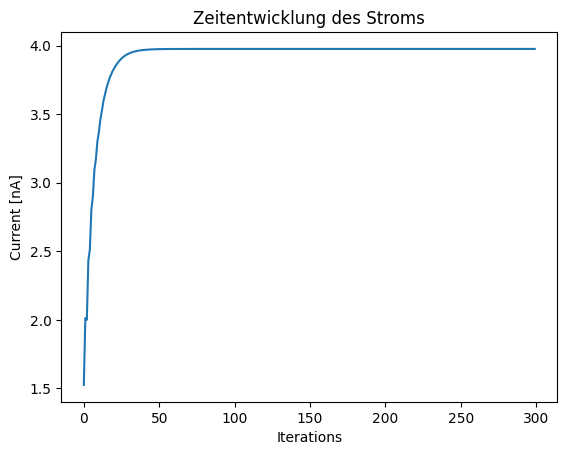

In [112]:
plt.plot(mf_currents)
plt.xlabel("Iterations")
plt.ylabel("Current [nA]")
plt.title("Zeitentwicklung des Stroms")

Mit den Konvergenzintervallen sähe das dann ja so aus:

In [113]:
I_true = 4.03487063557744          # angenommen das wäre der wahre Strom bei Elektrode 3... das würden wir ja durch einen langen KMC run herausfinden

In [114]:
mf_rel_errs = np.abs(I_true - mf_currents) / np.abs(I_true)   # relativer Fehler nach jeweiliger Anzahl iterationen

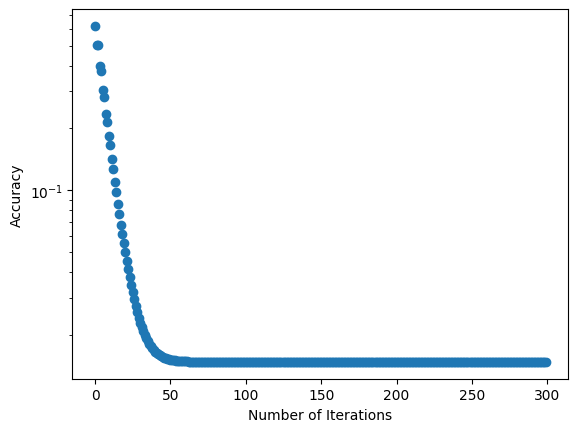

In [115]:
plt.scatter(np.arange(N), mf_rel_errs)
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")

plt.yscale("log")

Da die Iterationen alle gleich schnell gehen könnte man separat die mittlere Zeit für eine Iteration bestimmen:

In [116]:
mf_dt = 0.1 #[ms]   #Angenommen das wäre die Zeit pro Iteration für den MF1 Algorithmus (statistisch bestimmen, siehe Ende des Dokuments)

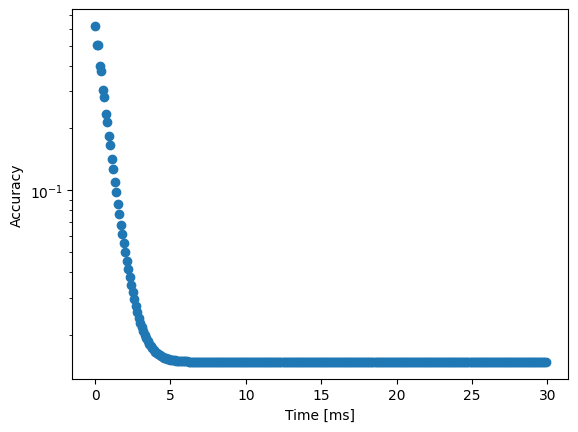

In [117]:
plt.scatter(np.arange(N) * mf_dt, mf_rel_errs)
plt.xlabel("Time [ms]")
plt.ylabel("Accuracy")

plt.yscale("log")

# 2. (schnelles) Meanfield zweiter Ordnung (QMF2)

Hier funktioniert sogar noch einfacher. Das QuickMeanField2-Objekt speichert seine aktuellen means und varianzen und man kann flexibel weiterrechnen lassen:

In [118]:
from module.simulation.quick_meanfield2 import QuickMeanField2

In [119]:
qmf2 = QuickMeanField2(net)

Hier gibt es zwei Lösungsverfahren: entweder numerische Integration *numeric_integration_solve()* oder das Verfahren mit ADAM. Am besten machen wir für den ADAM Versuch noch ein weiteres Objekt:

In [120]:
qmf2_ADAM = QuickMeanField2(net)
qmf2_ADAM.ADAM_solve(N = 0) # einmal ADAM initialisieren

Die Spannungskonfiguration ist ja noch durch das Netzwerk gesetzt.

In [121]:
N = 100
qmf2_currents = np.zeros(N)
qmf2_ADAM_currents = np.zeros(N)

for i in range(N):
    qmf2.numeric_integration_solve(N = 1, dt = 0.08, reset = False)     # wichtig ist hier reset auszuschalten, da er sonst immer von vorne anfängt
    qmf2_ADAM.ADAM_solve(N = 1, learning_rate = 0.1, reset = False)

    current = -qmf2.calc_expected_electrode_current(3)
    current_ADAM = -qmf2_ADAM.calc_expected_electrode_current(3)

    qmf2_currents[i] = np.copy(current)
    qmf2_ADAM_currents[i] = np.copy(current_ADAM)

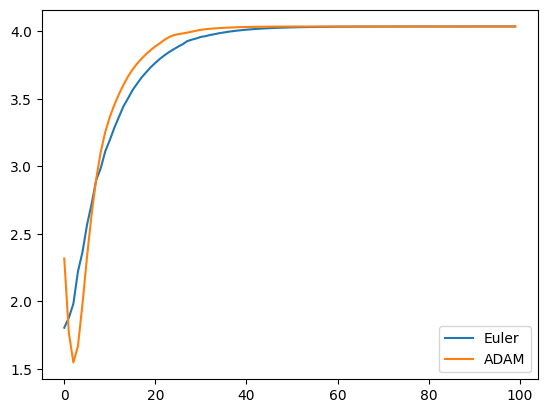

In [122]:
plt.plot(qmf2_currents, label = "Euler")
plt.plot(qmf2_ADAM_currents, label = "ADAM")

plt.legend()

jetzt die Genauigkeiten:

In [123]:
qmf2_dt = 0.3 #[ms]  # statistische Zeit pro step

qmf2_rel_errs = np.abs(I_true - qmf2_currents) / np.abs(I_true)             # Eulers method
qmf2_ADAM_rel_errs = np.abs(I_true - qmf2_ADAM_currents) / np.abs(I_true)   # ADAM method

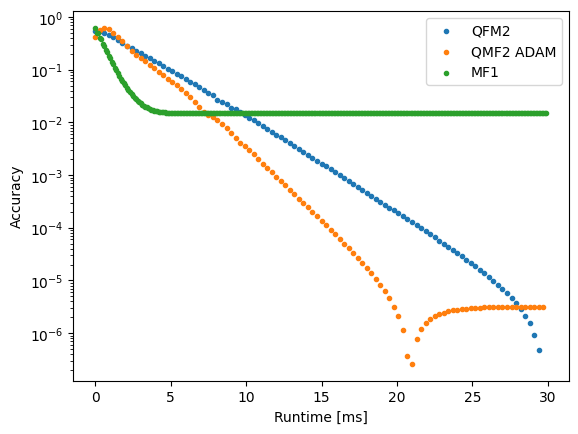

In [132]:
plt.scatter(np.arange(N) * qmf2_dt, qmf2_rel_errs, marker = ".", label = "QFM2")
plt.scatter(np.arange(N) * qmf2_dt, qmf2_ADAM_rel_errs, marker = ".", label = "QMF2 ADAM")


plt.scatter(np.arange(300) * mf_dt, mf_rel_errs, marker = ".", label = "MF1")

plt.legend()


plt.xlabel("Runtime [ms]")
plt.ylabel("Accuracy")

plt.yscale("log")

In [133]:
# jetzt fehlt da noch die KMC kurve :)

# am Ende könnte man dann die Durschscnittswerte für 100 versch. Spannungen bilden.
# ich kann auch selbst die Anzahl an notwendigen steps zählen und die Integrationsschrittweite der Algorithmen anpassen,
# du könntest vllt einmal bestimmen wie lange 1000 Iterationen im 4x4 system dauern:

In [136]:
# timeit

mf.numeric_integration_solve(N = 1000, dt = 0.1)

# timeit end

array([3.11829332, 3.55339815, 3.80099709, 4.43795496, 3.97158831,
       3.51529119, 3.32421634, 3.03844584, 4.71499715, 3.63657707,
       2.8101584 , 1.76258997, 5.9765282 , 4.05114721, 2.08484476,
       0.052342  ])

In [137]:
# timeit

qmf2.numeric_integration_solve(N = 1000, dt = 0.1)

# timeit end

In [138]:
# timeit

qmf2_ADAM.ADAM_solve(N = 1000)

# timeit end

In [139]:
#  das wäre denke ich am einfachsten :)

---